In [1]:
import lightcurves
import optical
import matplotlib.pyplot as mp
import numpy as np
import coordinates
import variables
%matplotlib inline


In [2]:
optical_folder = '/Users/jrneeley/CRRP/OpticalCatalogs/'
target = 'NGC3201'
folder = '/Users/jrneeley/CRRP/'+target+'/'
cluster_ra = '10:17:36.82'
cluster_dec = '-46:24:44.9'
center_ra, center_dec = coordinates.radec_string2deg(cluster_ra, cluster_dec)
catalog_data, dist = optical.read_fnl_for_cmd(optical_folder, target, center_ra, center_dec)

dtype1 = np.dtype([('id', 'S8'), ('period', float), ('var_type', 'S5')])
data = np.loadtxt(folder+'other.txt', dtype=dtype1)

datasets = optical.compile_datasets(target, old=0, folder=folder)

Reading optical catalog for NGC3201...
Finished reading optical catalog.


Datasets:

     Y0701  98131 2007-01-13 2007-01-23 k
    lcogt2  72058 2013-03-14 2013-03-23 r
     Y0704  17655 2007-03-31 2007-04-13 b
    zingle  16217 1996-04-16 1996-04-19 g
     west1  12278 2005-02-11 2005-02-13 m
     wfi13  11000 2003-06-04 2003-06-06 c
    lcogt3  10244 2014-03-02 2014-03-02 xkcd:brown
      lee4   8274 2012-02-18 2012-02-23 xkcd:coral
    ct1204   8248 2012-04-24 2012-04-24 xkcd:purple
  efosc08a   7947 2008-04-19 2008-04-19 xkcd:maroon
     bond6   7698 1998-04-17 1998-04-22 xkcd:olive
      wfi6   7019 2002-02-20 2002-02-20 xkcd:tan
      lee2   6096 2011-05-30 2011-06-03 xkcd:grey
     wfi22   5588 2000-02-27 2000-02-27 xkcd:teal
efosc1101b   5559 2011-01-21 2011-01-21 xkcd:tomato
     wfi41   5000 2012-02-24 2012-02-27 xkcd:orchid
     wfi11   4789 1999-12-05 1999-12-05 xkcd:goldenrod
     B1201   4742 2012-01-06 2012-01-11 xkcd:orange
     west2   4530 2005-05-05 2005-05-05 xkcd:

In [3]:
ind = 94

lcv_name = data['id'][ind]
lcv_file = folder+'lcvs/optical/'+target+lcv_name+'.lcv'
U, B, V, R, I = lightcurves.read_optical_lcv(lcv_file, old=0)
print lcv_name, data['var_type'][ind], data['period'][ind]
cc_period = data['period'][ind]


W117 ? nan


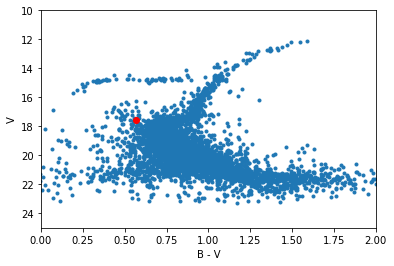

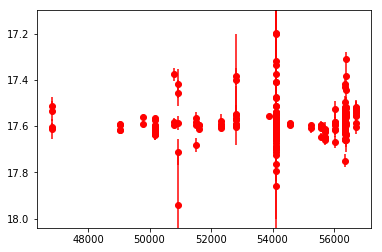

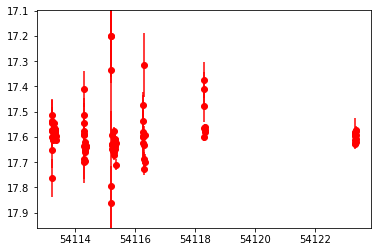

/Users/jrneeley/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 266 but corresponding boolean dimension is 104


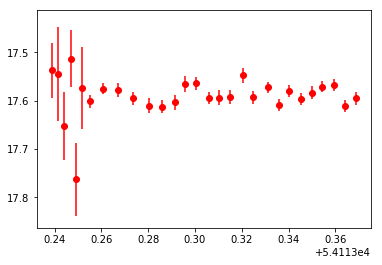

In [4]:
thres = 100
color = catalog_data['B'][dist < thres] - catalog_data['V'][dist < thres]
mag = catalog_data['V'][dist < thres]
scale = dist[dist < thres]
# ADD IN ERROR THRESHOLD
mp.scatter(color, mag, marker='.')
mp.ylim((25,10))
mp.xlim((0,2))
mp.xlabel('B - V')
mp.ylabel('V')


color_var = np.mean(B[0]) - np.mean(V[0])
mag_var = np.mean(V[0])
mp.plot(color_var, mag_var, 'ro')
mp.show()

lightcurves.plot_raw_optical_lcv(V)

# Find best dataset to use
sources_prefix = np.zeros(len(V[3]), dtype='S30')
for ind, string in enumerate(V[3]):
    sources_prefix[ind] = string.split(':')[0]
sources, counts = np.unique(sources_prefix, return_counts=True)
best_source = sources[counts == np.max(counts)]

num_obs_in_run = len(V[0][sources_prefix == best_source])
longest_dataset = np.zeros((4, num_obs_in_run), dtype=object)
longest_dataset[0][:] = V[0][sources_prefix == best_source]
longest_dataset[1][:] = V[1][sources_prefix == best_source]
longest_dataset[2][:] = V[2][sources_prefix == best_source]
longest_dataset[3][:] = V[3][sources_prefix == best_source]

lightcurves.plot_raw_optical_lcv(longest_dataset)


# find night with the most data

obs_times = np.array(longest_dataset[2], dtype=float)
nights = np.round(obs_times, 0)
uniq_nights, counts = np.unique(nights, return_counts=True)
order = np.argsort(counts)
best_nights = uniq_nights[order]
best_night = uniq_nights[counts == np.max(counts)][0]
num_obs_in_night = len(V[2][nights == best_night])

longest_night = np.zeros((4, num_obs_in_night), dtype=object)
longest_night[0][:] = longest_dataset[0][nights == best_night]
longest_night[1][:] = longest_dataset[1][nights == best_night]
longest_night[2][:] = longest_dataset[2][nights == best_night]
longest_night[3][:] = longest_dataset[3][nights == best_night]

lightcurves.plot_raw_optical_lcv(longest_night)


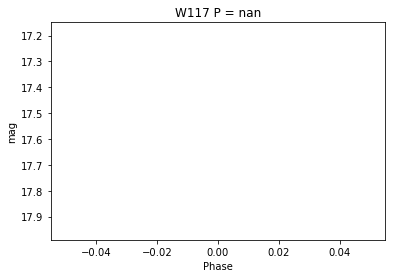

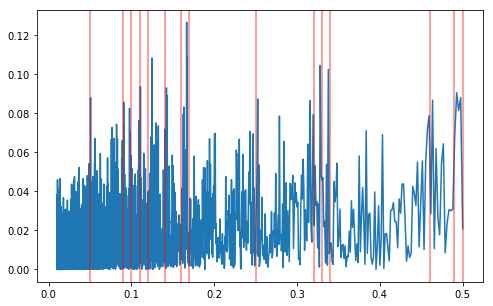

[ 0.05  0.09  0.1   0.11  0.12  0.14  0.16  0.17  0.25  0.32  0.33  0.34
  0.46  0.49  0.5 ]


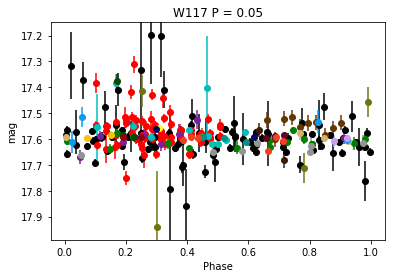

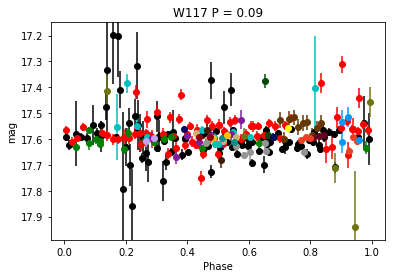

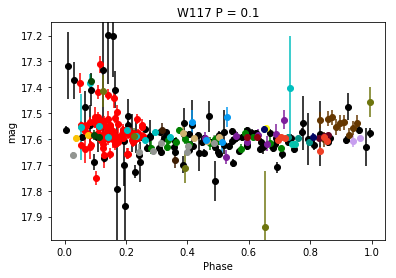

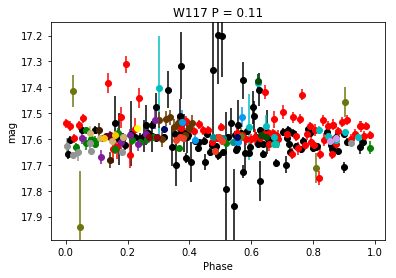

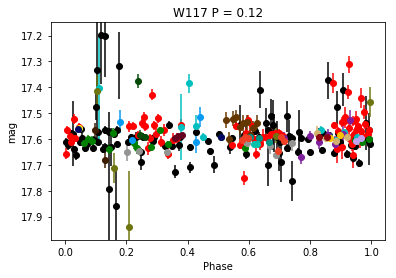

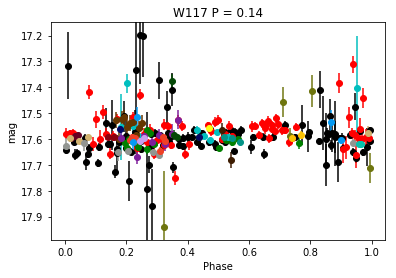

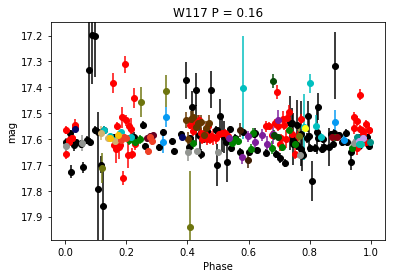

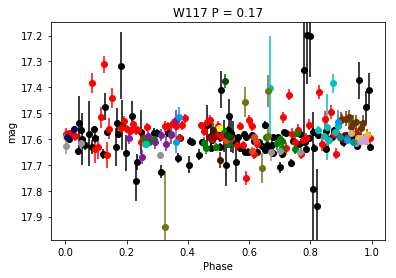

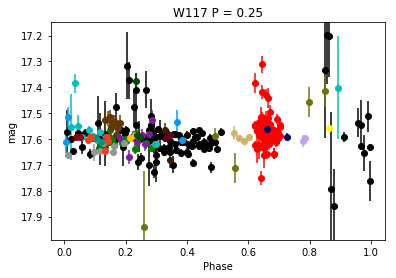

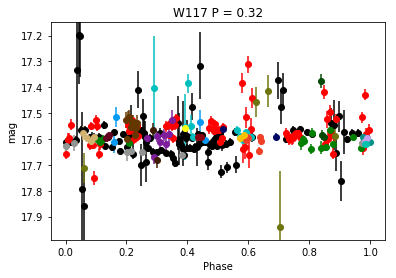

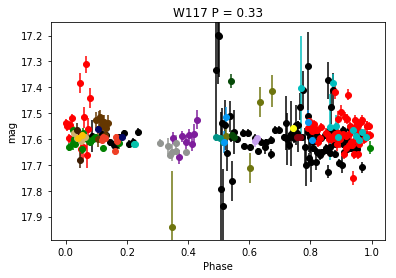

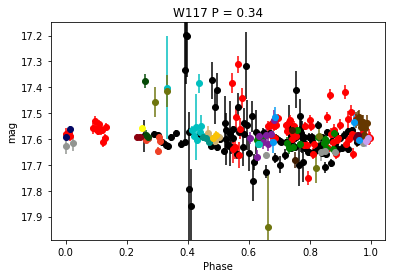

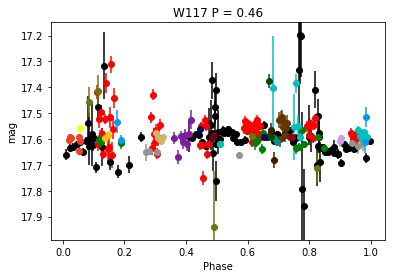

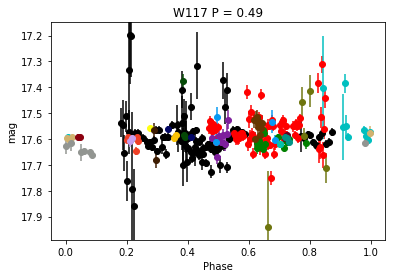

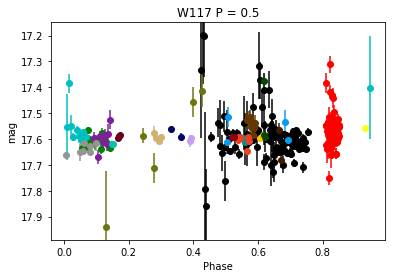

In [8]:
lightcurves.plot_phased_optical_one_band(V, cc_period, lcv_name, datasets)

#new_p = lightcurves.period_search_hybrid(V, cc_period, lcv_name)
#lightcurves.plot_phased_optical_one_band(V, new_period, lcv_name, datasets)

candidate_periods = variables.candidate_variables(V, lcv_name, min_period=0.01, 
                                                  max_period=0.5, precision=2, grid_num=10000)
print candidate_periods
num_periods = len(candidate_periods)

for period in candidate_periods:
    if period == 0:
        continue
   # new_p = lightcurves.period_search_hybrid(V, period, lcv_name, search_window=0.01, num_investigate=1, precision=10e7)
    lightcurves.plot_phased_optical_one_band(V, period, lcv_name, datasets)